### Exploration of processed bulk ATAC and RNA data

In [60]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
import anndata as ad
import muon as mu
import os
import re
from bs4 import BeautifulSoup

In [61]:
# set filepath parameters

datafolder = '/projectnb/paxlab/EnhancerDiscovery/data'
atac_datafolder = f'{datafolder}/Bulk-ATAC-Heart-Lung-Liver_Human_FBs/NF_out'
rna_datafolder = f'{datafolder}/Bulk-Ribo-Depleted-RNAseq-Heart-Lung-Liver_Human_FBs/hFB_riboDepletedBulkRnaSeq/NF_out'

#### RNA QC

In [62]:
rna_qc = f'{rna_datafolder}/multiqc/star_salmon/multiqc_report_data'

<Axes: xlabel='mean', ylabel='Count'>

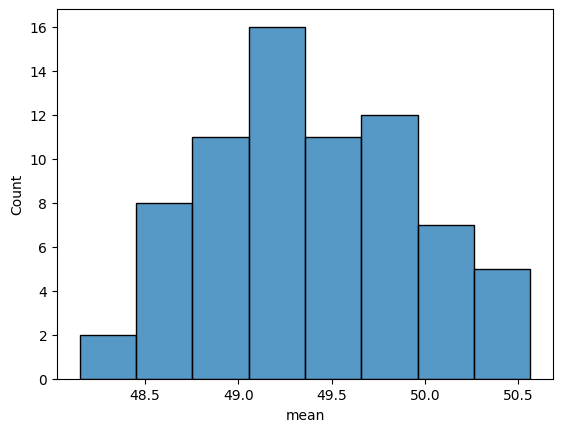

In [63]:
# gc content
gc_content = pd.read_table(f'{rna_qc}/mqc_fastqc_per_sequence_gc_content_plot_Percentages.txt', index_col=0)
gc_content['mean'] = [np.mean([float(col) * row[col] for col in gc_content.columns]) for _, row in gc_content.iterrows()]
sns.histplot(gc_content, x='mean')

<Axes: >

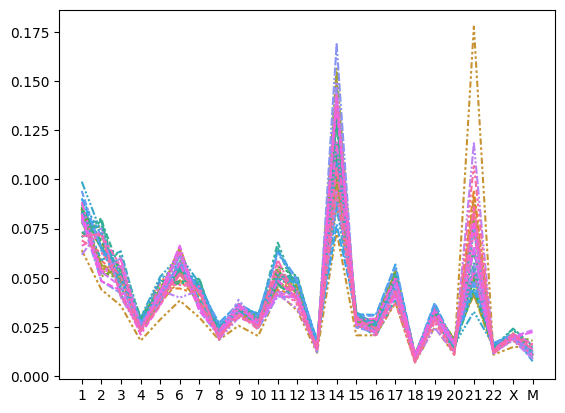

In [64]:
# mapped read coverage
mapped_reads = pd.read_table(f'{rna_qc}/mqc_samtools-idxstats-mapped-reads-plot_Normalised_Counts.txt', index_col=0)
mapped_reads.rename(columns = lambda c: c[3:], inplace=True)
sns.lineplot(mapped_reads.T.drop(index=['1_KI270713v1_random', '22_KI270733v1_random', 'Un_GL000220v1']), legend=None)

<Axes: xlabel='pct_mapped', ylabel='Count'>

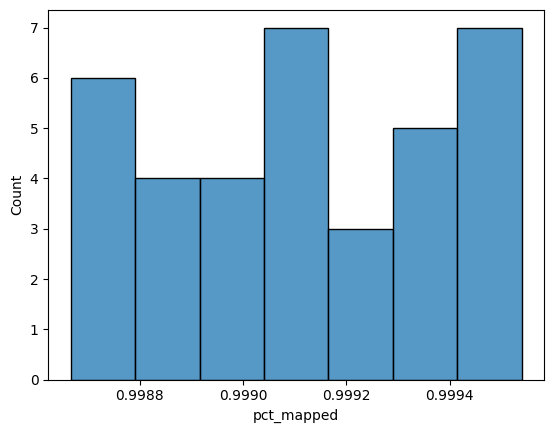

In [65]:
# total pct mapped reads
mapped_reads['pct_mapped'] = [sum(row) for _, row in mapped_reads.iterrows()]
sns.histplot(mapped_reads, x='pct_mapped')

<Axes: xlabel='Total reads', ylabel='Count'>

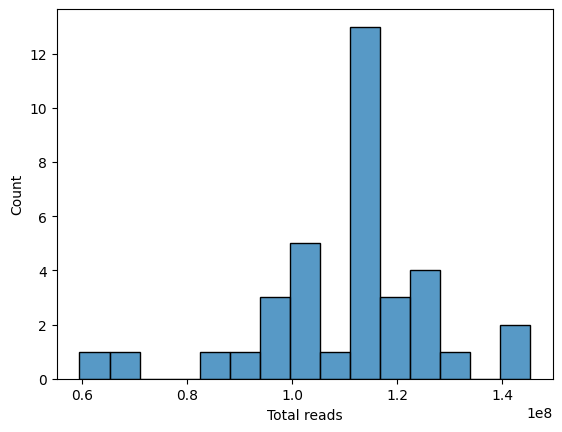

In [66]:
# Number of reads mapped
raw_mapped_reads = pd.read_table(f'{rna_qc}/mqc_samtools-idxstats-mapped-reads-plot_Raw_Counts.txt', index_col=0)
raw_mapped_reads['Total reads'] = raw_mapped_reads.aggregate('sum', axis=1)
sns.histplot(raw_mapped_reads, x = 'Total reads', bins=15)

### ATAC QC

In [67]:
atac_qc = f'{atac_datafolder}/fastqc'

In [68]:
sample_to_stats = {}
for file in os.listdir(atac_qc):
  if not os.path.isfile(f'{atac_qc}/{file}'):
    continue
  sample = file.split('_fastqc.')[0]
  sample_stats = {}
  with open(f'{atac_qc}/{file}', 'r') as qc:
    soup = BeautifulSoup(qc.read(), 'html.parser')
    for li in soup.find(name='ul').children:
      img, desc = li.children
      sample_stats[desc.text] = img.attrs['alt'][1:-1]
  sample_to_stats[sample] = sample_stats
atac_qc_df = pd.DataFrame(sample_to_stats).T

In [69]:
atac_qc_df.head()

,Basic Statistics,Per base sequence quality,Per tile sequence quality,Per sequence quality scores,Per base sequence content,Per sequence GC content,Per base N content,Sequence Length Distribution,Sequence Duplication Levels,Overrepresented sequences,Adapter Content
TGFB_JQ1_Heart_REP1_T1_2,PASS,PASS,PASS,PASS,FAIL,PASS,PASS,PASS,PASS,WARNING,WARNING
TGFB_Heart_REP2_T1_2,PASS,PASS,PASS,PASS,FAIL,PASS,PASS,PASS,PASS,WARNING,WARNING
TGFB_Lung_REP1_T1_2,PASS,PASS,PASS,PASS,FAIL,PASS,PASS,PASS,PASS,WARNING,PASS
TGFB_JQ1_Liver_REP1_T1_1,PASS,PASS,FAIL,PASS,FAIL,PASS,PASS,PASS,PASS,PASS,WARNING
TGFB_Lung_REP3_T1_1,PASS,PASS,FAIL,PASS,FAIL,PASS,PASS,PASS,PASS,PASS,WARNING


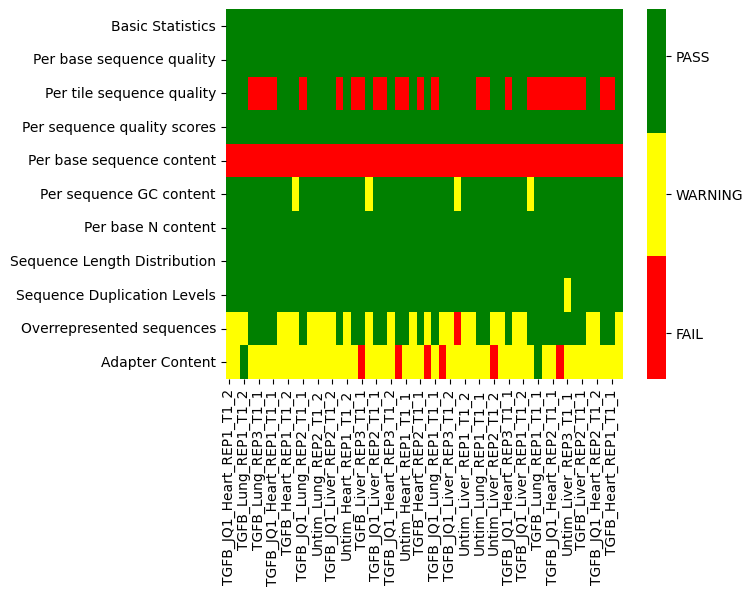

In [70]:
ax = sns.heatmap(atac_qc_df.T.map(lambda el: 2 if el == 'PASS' else 1 if el == 'WARNING' else 0), cmap=['red', 'yellow', 'green'])
colorbar = ax.collections[0].colorbar
colorbar.set_ticks(colorbar.get_ticks(minor=False)[1:9:3], labels = ['FAIL', 'WARNING', 'PASS'])

#### Diving into the samples

In [71]:
# Using muon (https://github.com/scverse/muon) for multiomic data structure
# First load into individual AnnData structures

rna_tpm = f'{rna_datafolder}/star_salmon/salmon.merged.transcript_tpm.tsv'
rna_df = pd.read_table(rna_tpm, index_col=0)
genes = rna_df['gene_id']
rna_df.drop(columns = 'gene_id', inplace=True)

rna_adata = ad.AnnData(rna_df.T)

In [73]:
rna_adata.var['gene'] = genes
rna_adata.obs['organ'] = [re.search(r"Heart|Lung|Liver", sample).group(0) for sample in rna_adata.obs_names]
rna_adata.obs['condition'] = [re.search(r"Unstim|TGFb(_._JQ1)?", sample).group(0).replace('TGFb_._', '') for sample in rna_adata.obs_names]
rna_adata

AnnData object with n_obs × n_vars = 36 × 87398
    obs: 'organ', 'condition'
    var: 'gene'

In [129]:
palette = {'Unstim': '#2ca02c', 'TGFb': '#d62728', 'JQ1': '#1f77b4'}

<Axes: xlabel='organ', ylabel='Count'>

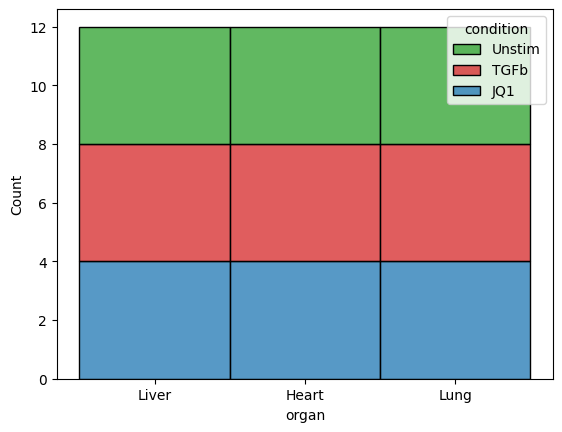

In [133]:
sns.histplot(rna_adata.obs, x='organ', hue='condition', multiple='stack', palette=palette, hue_order=palette.keys())

In [74]:
atac_peaks = f'{atac_datafolder}/bwa/merged_library/macs2/broad_peak/consensus/consensus_peaks.mLb.clN.featureCounts.txt'
atac_df = pd.read_table(atac_peaks, index_col=0, header=1)
atac_vars = atac_df[['Chr', 'Start', 'End', 'Strand', 'Length']]
atac_df.drop(columns = ['Chr', 'Start', 'End', 'Strand', 'Length'], inplace=True)

atac_adata = ad.AnnData(atac_df.T)

In [75]:
atac_adata.var = atac_vars
atac_adata.obs['organ'] = [re.search(r"Heart|Lung|Liver", sample).group(0) for sample in atac_adata.obs_names]
atac_adata.obs['condition'] = [re.search(r"Untim|TGFB(_JQ1)?", sample).group(0).replace('TGFB_', '').replace('TGFB', 'TGFb').replace('Untim', 'Unstim') for sample in atac_adata.obs_names]
atac_adata

AnnData object with n_obs × n_vars = 26 × 164814
    obs: 'organ', 'condition'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length'

<Axes: xlabel='organ', ylabel='Count'>

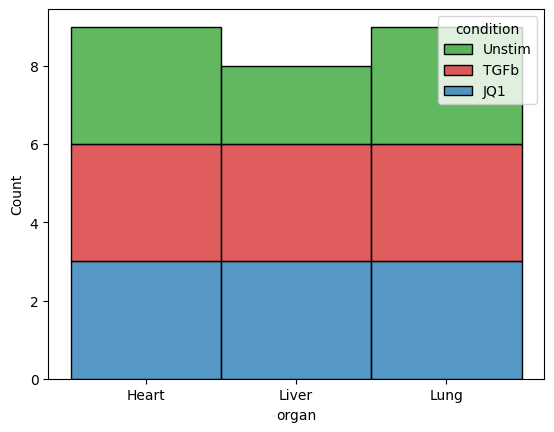

In [132]:
sns.histplot(atac_adata.obs, x='organ', hue='condition', multiple='stack', palette=palette, hue_order=palette.keys())

In [108]:
# TODO: Figure out how to join these samples

In [81]:
rna_adata.obs_names

Index(['X10_Liver_FB_Unstim_1.1', 'X11_Liver_FB_Unstim_1.2',
       'X13_Liver_FB_TGFb_1.1', 'X14_Liver_FB_TGFb_1.2',
       'X16_Liver_FB_TGFb_._JQ1_1.1', 'X18_Liver_FB_TGFb_._JQ1_1.3',
       'X19_Heart_FB_Unstim_1.1', 'X2_Lung_FB_Unstim_1.2',
       'X20_Heart_FB_Unstim_1.2', 'X23_Heart_FB_TGFb_1.2',
       'X24_Heart_FB_TGFb_1.3', 'X25_Heart_FB_TGFb_._JQ1_1.1',
       'X26_Heart_FB_TGFb_._JQ1_1.2', 'X28_Lung_FB_Unstim_2.1',
       'X3_Lung_FB_Unstim_1.3', 'X30_Lung_FB_Unstim_2.3',
       'X31_Lung_FB_TGFb_2.1', 'X32_Lung_FB_TGFb_2.2',
       'X34_Lung_FB_TGFb_._JQ1_2.1', 'X35_Lung_FB_TGFb_._JQ1_2.2',
       'X37_Liver_FB_Unstim_2.1', 'X38_Liver_FB_Unstim_2.2',
       'X4_Lung_FB_TGFb_1.1', 'X41_Liver_FB_TGFb_2.2', 'X42_Liver_FB_TGFb_2.3',
       'X44_Liver_FB_TGFb_._JQ1_2.2', 'X45_Liver_FB_TGFb_._JQ1_2.3',
       'X46_Heart_FB_Unstim_2.1', 'X47_Heart_FB_Unstim_2.2',
       'X5_Lung_FB_TGFb_1.2', 'X50_Heart_FB_TGFb_2.2', 'X51_Heart_FB_TGFb_2.3',
       'X52_Heart_FB_TGFb_._JQ1_2.1',

In [80]:
atac_adata.obs_names

Index(['Untim_Heart_REP1.mLb.clN.sorted.bam',
       'TGFB_JQ1_Heart_REP1.mLb.clN.sorted.bam',
       'TGFB_Heart_REP2.mLb.clN.sorted.bam',
       'TGFB_Liver_REP3.mLb.clN.sorted.bam',
       'Untim_Heart_REP2.mLb.clN.sorted.bam',
       'TGFB_Liver_REP1.mLb.clN.sorted.bam',
       'TGFB_JQ1_Heart_REP3.mLb.clN.sorted.bam',
       'TGFB_Heart_REP3.mLb.clN.sorted.bam',
       'TGFB_Lung_REP2.mLb.clN.sorted.bam',
       'TGFB_JQ1_Lung_REP2.mLb.clN.sorted.bam',
       'TGFB_Lung_REP1.mLb.clN.sorted.bam',
       'TGFB_JQ1_Heart_REP2.mLb.clN.sorted.bam',
       'TGFB_JQ1_Liver_REP2.mLb.clN.sorted.bam',
       'Untim_Lung_REP2.mLb.clN.sorted.bam',
       'TGFB_Heart_REP1.mLb.clN.sorted.bam',
       'TGFB_JQ1_Liver_REP3.mLb.clN.sorted.bam',
       'TGFB_Lung_REP3.mLb.clN.sorted.bam',
       'Untim_Liver_REP2.mLb.clN.sorted.bam',
       'TGFB_JQ1_Lung_REP3.mLb.clN.sorted.bam',
       'Untim_Liver_REP1.mLb.clN.sorted.bam',
       'TGFB_JQ1_Liver_REP1.mLb.clN.sorted.bam',
       'TGFB_Liver_REP2.

In [76]:
mdata = mu.MuData({'rna': rna_adata, 'atac': atac_adata})
mdata

/projectnb/paxlab/dillon/OrganFibrosisConditionalGRNs/.venv/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/projectnb/paxlab/dillon/OrganFibrosisConditionalGRNs/.venv/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 62 × 252212
  2 modalities
    rna:	36 x 87398
      obs:	'organ', 'condition'
      var:	'gene'
    atac:	26 x 164814
      obs:	'organ', 'condition'
      var:	'Chr', 'Start', 'End', 'Strand', 'Length'

In [99]:
peak_annotation = pd.read_table(f'{atac_datafolder}/bwa/merged_library/macs2/broad_peak/consensus/consensus_peaks.mLb.clN.annotatePeaks.txt')
peak_annotation.rename(columns = {
  'Gene Name': 'gene',
  'Distance to TSS': 'distance',
  'Annotation': 'peak_type',
  'Chr': 'chrom',
  'Start': 'start',
  'End': 'end'
}, inplace=True)
mu.atac.tl.add_peak_annotation(mdata, peak_annotation)

In [79]:
mu.tl.mofa(mdata)

IndexError: Not all the observations are the same across modalities. Please run `mdata.intersect_obs()` to subset the data or devise a strategy with `use_obs` ('union' or 'intersection')